In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# CODIGO PARA PREPROCESADO Y DIVISÓN EN TRAIN,TEST Y VALIDACIÓN


In [2]:
#Directorio base
base_dir = 'poses_images'

#Carpetas de violencia y no violencia
violence_dir = os.path.join(base_dir, 'Violence')
nonviolence_dir = os.path.join(base_dir, 'NonViolence')

#Listas para alamcenar los frames
violence_frames=[]
nonviolence_frames=[]

'''
for video_folder in os.listdir(violence_dir):
    video_folder_path = os.path.join(violence_dir, video_folder)
    for frame in os.listdir(video_folder_path):
        frame_path = os.path.join(video_folder_path, frame)
        violence_frames.append(frame_path)
        break

for video_folder in os.listdir(nonviolence_dir):
    video_folder_path = os.path.join(nonviolence_dir, video_folder)
    for frame in os.listdir(video_folder_path):
        frame_path = os.path.join(video_folder_path, frame)
        nonviolence_frames.append(frame_path)
        break

# Etiquetas '0': nonviolence y '1':violence
labels_violence = [1] * len(violence_frames)
labels_nonviolence = [0] * len(nonviolence_frames)

image_paths = violence_frames + nonviolence_frames
labels = labels_violence + labels_nonviolence

# Dividir los datos en entrenamiento, validación y prueba con estratificación

#División en train y test
train_paths, temp_test_paths, train_labels, temp_test_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels
)

#División de test en test y validation
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_test_paths, temp_test_labels, test_size=2/3, stratify=temp_test_labels
)
'''

"\nfor video_folder in os.listdir(violence_dir):\n    video_folder_path = os.path.join(violence_dir, video_folder)\n    for frame in os.listdir(video_folder_path):\n        frame_path = os.path.join(video_folder_path, frame)\n        violence_frames.append(frame_path)\n        break\n\nfor video_folder in os.listdir(nonviolence_dir):\n    video_folder_path = os.path.join(nonviolence_dir, video_folder)\n    for frame in os.listdir(video_folder_path):\n        frame_path = os.path.join(video_folder_path, frame)\n        nonviolence_frames.append(frame_path)\n        break\n\n# Etiquetas '0': nonviolence y '1':violence\nlabels_violence = [1] * len(violence_frames)\nlabels_nonviolence = [0] * len(nonviolence_frames)\n\nimage_paths = violence_frames + nonviolence_frames\nlabels = labels_violence + labels_nonviolence\n\n# Dividir los datos en entrenamiento, validación y prueba con estratificación\n\n#División en train y test\ntrain_paths, temp_test_paths, train_labels, temp_test_labels = tra

In [3]:
violence_videos = os.listdir(violence_dir)
labels_violence = [1] * len(violence_videos)
nonviolence_videos = os.listdir(nonviolence_dir)
labels_nonviolence = [0] * len(nonviolence_videos)
labels = labels_violence + labels_nonviolence
train_val, test, train_val_labels, test_labels = train_test_split(violence_videos+nonviolence_videos, labels, test_size=.1, stratify=labels, shuffle=True)
train, validate, train_labels, validate_labels = train_test_split(train_val, train_val_labels, test_size=0.2, stratify=train_val_labels, shuffle=True)

In [4]:
train_dataset = [
    os.path.join(
        violence_dir if train_labels[i] == 1 else nonviolence_dir, video, frame
    )
    for i, video in enumerate(train)
    for frame in os.listdir(
        os.path.join(violence_dir if train_labels[i] == 1 else nonviolence_dir, video)
    )
]

train_labels = [0 if 'NonViolence' in frame else 1 for frame in train_dataset]

In [5]:
validate_dataset = [
    os.path.join(
        violence_dir if validate_labels[i] == 1 else nonviolence_dir, video, frame
    )
    for i, video in enumerate(validate)
    for frame in os.listdir(
        os.path.join(violence_dir if validate_labels[i] == 1 else nonviolence_dir, video)
    )
]

validate_labels = [0 if 'NonViolence' in frame else 1 for frame in validate_dataset]

In [6]:
test_dataset = [
    os.path.join(
        violence_dir if test_labels[i] == 1 else nonviolence_dir, video, frame
    )
    for i, video in enumerate(test)
    for frame in os.listdir(
        os.path.join(violence_dir if test_labels[i] == 1 else nonviolence_dir, video)
    )
]

test_labels = [0 if 'NonViolence' in frame else 1 for frame in test_dataset]

In [7]:
#Función de preprocesamiento
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))  # Redimensionar a 224x224. Los frames ya están guardados en esa dimensión pero por si acaso
    image = img_to_array(image)
    image = preprocess_input(image)  # Normalización para VGG16
    return image

In [8]:
train_images = np.array([load_and_preprocess_image(img_path) for img_path in train_dataset])
val_images = np.array([load_and_preprocess_image(img_path) for img_path in validate_dataset])
test_images = np.array([load_and_preprocess_image(img_path) for img_path in test_dataset])

In [9]:
# Convertir las etiquetas a arrays
train_labels = np.array(train_labels)
val_labels = np.array(validate_labels)
test_labels = np.array(test_labels)

# CARGA DEL MODELO VGG16 SIN LA CAPA SUPERIOR (CAPA DE CLASIFICACIÓN QUE AÑADIMOS)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

In [11]:
# Cargar el modelo VGG16 preentrenado sin la capa superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
base_model.trainable = False

model=Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) #Clasificación binaria (violence or nonviolence)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
history = model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=10,
    validation_data=(val_images, val_labels)
)

Epoch 1/10
86/86 [==============================] - 25s 176ms/step - loss: 9.5016 - accuracy: 0.7924 - val_loss: 3.1788 - val_accuracy: 0.7418
Epoch 2/10
86/86 [==============================] - 11s 134ms/step - loss: 0.6647 - accuracy: 0.8903 - val_loss: 0.7934 - val_accuracy: 0.8160
Epoch 3/10
86/86 [==============================] - 11s 134ms/step - loss: 0.2497 - accuracy: 0.9299 - val_loss: 0.9295 - val_accuracy: 0.8086
Epoch 4/10
86/86 [==============================] - 12s 134ms/step - loss: 0.1780 - accuracy: 0.9435 - val_loss: 0.9010 - val_accuracy: 0.8190
Epoch 5/10
86/86 [==============================] - 12s 135ms/step - loss: 0.1966 - accuracy: 0.9468 - val_loss: 0.8817 - val_accuracy: 0.8116
Epoch 6/10
86/86 [==============================] - 11s 134ms/step - loss: 0.1628 - accuracy: 0.9472 - val_loss: 0.9009 - val_accuracy: 0.8160
Epoch 7/10
86/86 [==============================] - 12s 134ms/step - loss: 0.1224 - accuracy: 0.9563 - val_loss: 0.8071 - val_accuracy: 0.8368

In [13]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")

12/12 [==============================] - 3s 282ms/step - loss: 1.2960 - accuracy: 0.7701
Test accuracy: 0.7701


In [14]:
"""
# Save weights
model.save_weights(file_weights)

# Save history
with open(file_history, 'w') as f:
    json.dump(history.history, f)
"""

"\n# Save weights\nmodel.save_weights(file_weights)\n\n# Save history\nwith open(file_history, 'w') as f:\n    json.dump(history.history, f)\n"

In [15]:
"""
# 1. Load history
with open(file_history, "rb") as f:
    history = json.load(f)

# 2. Plot loss
plt.figure()
num_epochs = len(history['loss'])
plt.plot(range(1, num_epochs + 1), history['loss'])
plt.plot(range(1, num_epochs + 1), history['val_loss'])
plt.title('Loss (cross-entropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
max_loss = 1.1*max(history['loss'] + history['val_loss'])
plt.ylim([0, max_loss])
plt.savefig(fig_results_loss)
plt.show()

# 3. Plot accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), 100*np.array(history['accuracy']))
plt.plot(range(1, num_epochs + 1), 100*np.array(history['val_accuracy']))
plt.title('Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim([0, 100.0])
plt.savefig(fig_results_accuracy)
plt.show()
"""

'\n# 1. Load history\nwith open(file_history, "rb") as f:\n    history = json.load(f)\n\n# 2. Plot loss\nplt.figure()\nnum_epochs = len(history[\'loss\'])\nplt.plot(range(1, num_epochs + 1), history[\'loss\'])\nplt.plot(range(1, num_epochs + 1), history[\'val_loss\'])\nplt.title(\'Loss (cross-entropy)\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Epoch\')\nplt.legend([\'Train\', \'Test\'], loc=\'upper right\')\nmax_loss = 1.1*max(history[\'loss\'] + history[\'val_loss\'])\nplt.ylim([0, max_loss])\nplt.savefig(fig_results_loss)\nplt.show()\n\n# 3. Plot accuracy\nplt.figure()\nplt.plot(range(1, num_epochs + 1), 100*np.array(history[\'accuracy\']))\nplt.plot(range(1, num_epochs + 1), 100*np.array(history[\'val_accuracy\']))\nplt.title(\'Accuracy\')\nplt.ylabel(\'Accuracy (%)\')\nplt.xlabel(\'Epoch\')\nplt.legend([\'Train\', \'Test\'], loc=\'upper left\')\nplt.ylim([0, 100.0])\nplt.savefig(fig_results_accuracy)\nplt.show()\n'

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

22/22 [==============================] - 3s 109ms/step


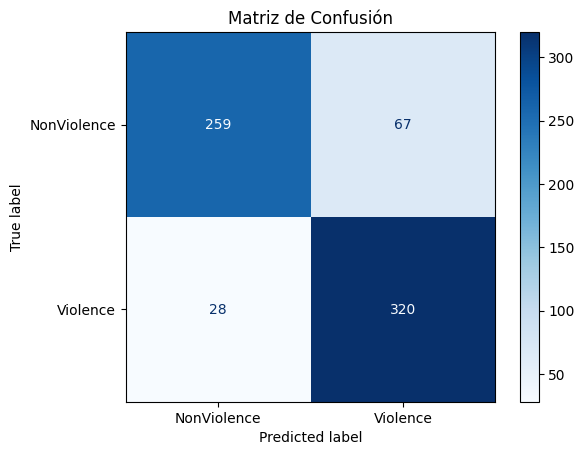

In [17]:
# Obtener predicciones del modelo en el conjunto de prueba
val_predictions = model.predict(val_images)
val_predictions = (val_predictions > 0.85).astype(int)  # Convertir probabilidades a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(val_labels, val_predictions)

# Mostrar la matriz de confusión con etiquetas claras
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NonViolence", "Violence"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

---

In [35]:
# Our validation video
final_val_path = os.path.join('poses_images', 'Validation', 'video_1')
data = os.listdir(final_val_path)
data = [os.path.join(final_val_path, d) for d in data]
final = np.array([load_and_preprocess_image(img_path) for img_path in data])
preds = model.predict(final)
for prediction in preds:
    print(np.round(prediction, 2))

1/1 [==============================] - 0s 40ms/step
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.02]
[0.]
[0.01]
[0.17]
[0.]
[0.01]
[0.]
[0.]
[0.]
[0.]
